In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install fastai==1.0.61

In [3]:
# !pip install timm

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image
import os
from glob import glob
import cv2
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms
import timm

# from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F


In [5]:
from utils import interleave, de_interleave, show_batch, AverageMeter, show_grid, get_config
from learner import SemiSupLearning, SupLearning
from dataset import get_data

In [6]:
config = get_config('./configs/local_supervised_groupbycat.yaml')

In [7]:
df_anno = pd.read_csv(config['DATA']['ANNO'])
df_anno.head()

,Organ,Classification,Finding,Image,Categories,is_valid,Groupby_Categories
0,lower-gi-tract,therapeutic-interventions,dyed-resection-margins,lower-gi-tract/therapeutic-interventions/dyed-...,0,False,0
1,lower-gi-tract,quality-of-mucosal-views,bbps-2-3,lower-gi-tract/quality-of-mucosal-views/bbps-2...,0,False,0
2,upper-gi-tract,pathological-findings,barretts-short-segment,upper-gi-tract/pathological-findings/barretts-...,1,False,5
3,lower-gi-tract,quality-of-mucosal-views,bbps-0-1,lower-gi-tract/quality-of-mucosal-views/bbps-0...,0,False,0
4,upper-gi-tract,anatomical-landmarks,z-line,upper-gi-tract/anatomical-landmarks/z-line/87c...,0,False,0


In [8]:
train_dl, valid_dl = get_data(config, df_anno, is_visual=False)

In [9]:
model = nn.Sequential(timm.create_model('densenet161',pretrained=True,num_classes = config['MODEL']['NUM_CLASSES']))

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [11]:
if config.TRAIN.IS_SSL:
    classifier = SemiSupLearning(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
else:
    classifier = SupLearning(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
classifier.get_dataloader(train_dl, valid_dl)
classifier.get_config(config)

In [12]:
# classifier.fit()

In [13]:
# classifier.save_checkpoint('./')

In [14]:
classifier.load_checkpoint('D:\\model\\endoscopy\\hyper_kvasir\\baseline_densenet161\\05_18_2022_15_37_33_groupby.pth')

100%|████████████████████████████████████████████████| 334/334 [16:22<00:00,  2.94s/it, loss=0.421]


Metric:
{'micro/precision': 0.9099774943735934, 'micro/recall': 0.9099774943735934, 'micro/f1': 0.9099774943735934, 'macro/precision': 0.6403056552216306, 'macro/recall': 0.6803950967737601, 'macro/f1': 0.6575961928957965}
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2007
           1       0.08      0.11      0.10         9
           2       0.94      0.86      0.90       241
           3       0.66      0.76      0.70        82
           4       0.44      0.55      0.49        97
           5       0.75      0.86      0.80       230

    accuracy                           0.91      2666
   macro avg       0.64      0.68      0.66      2666
weighted avg       0.92      0.91      0.91      2666



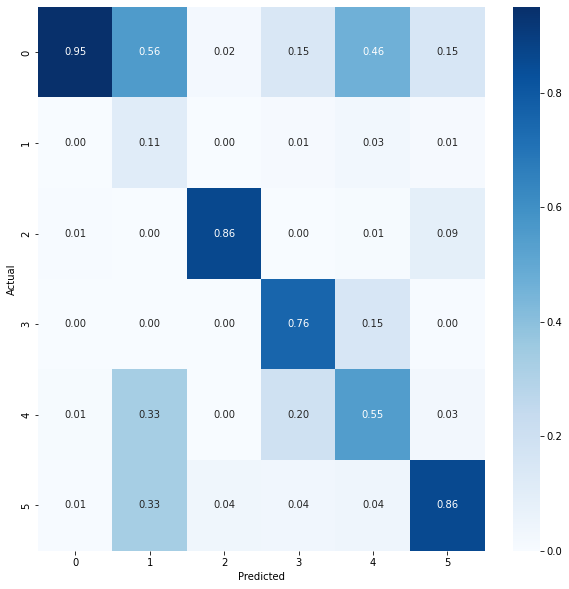

In [15]:
valid_loss, valid_metric = classifier.evaluate_one(True, True, True)